In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from value_F import valF, gradF, hessF
from minimizers import newton
import jax

jax.config.update("jax_enable_x64", True)

# Read data from Excel files
images = pd.read_excel('body.xlsx', usecols='A:J', header=None).to_numpy()
camera_coordinates = pd.read_excel('souradnice.xlsx', usecols='A:F', header=None).to_numpy()

# Define constants
beta_min = 0.3  # Lower Bound of Scaling Factor
beta_max = 0.7  # Upper Bound of Scaling Factor
pCR = 0.5  # Crossover Probability

# Conversion between global coordinate system and ELVAC coordinate system
X = camera_coordinates
X[:, 3:6] = X[:, 3:6] * np.pi / 180

# Extracting data from images
aa = images[:, 0:2]
bb = images[:, 2:4]
cc = images[:, 4:6]
dd = images[:, 6:8]
ee = images[:, 8:10]

# Transformation matrix - Bail-Beremlijski system to ELVAC system
Transform_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, -1]])
Transform_matrix_rotation = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])

# Calibration target
S = np.array([0, 0, 0, 0.05, 0.05, 0, 0.05, -0.05, 0, -0.05, -0.05, 0, -0.05, 0.05, 0]) * 1e3
S = jnp.array(S * 1e-3, dtype=jnp.float64)
# Vector definitions
v = np.array([0, 0, -1])
n = np.array([0, 1, 0])
L = 9.5 * 1e-3

# Initialize F_val as an empty list

F_val1 = np.zeros(102)
F_val2 = np.zeros(102)

SS = np.array([2592 / 2, 1944 / 2])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


It: 0 nit: 2, F: 8.872952883243047e-05
It: 1 nit: 5, F: 7.274641438559907e-05
It: 2 nit: 4, F: 8.170694418242766e-05
It: 3 nit: 4, F: 8.070934569193301e-05
It: 4 nit: 4, F: 0.00010337894289588736
It: 5 nit: 5, F: 0.00010129265334079956
It: 6 nit: 5, F: 9.337032149232591e-05
It: 7 nit: 5, F: 7.754888957941233e-05
It: 8 nit: 4, F: 7.457436516868977e-05
It: 9 nit: 5, F: 8.432752335888834e-05
It: 10 nit: 4, F: 7.961224838171646e-05
It: 11 nit: 5, F: 0.00011297945786933476
It: 12 nit: 4, F: 8.58443970079672e-05
It: 13 nit: 4, F: 7.290747787731103e-05
It: 14 nit: 4, F: 7.895882026510054e-05
It: 15 nit: 5, F: 0.00010761331994857863
It: 16 nit: 5, F: 8.431960642816973e-05
It: 17 nit: 5, F: 6.776054374547688e-05
It: 18 nit: 5, F: 8.285718899930744e-05
It: 19 nit: 5, F: 7.942653369593953e-05
It: 20 nit: 4, F: 0.0001017837880728365
It: 21 nit: 4, F: 9.79200684956304e-05
It: 22 nit: 4, F: 8.560252794826738e-05
It: 23 nit: 5, F: 7.32081755071062e-05
It: 24 nit: 4, F: 9.115165538290561e-05
It: 25 ni

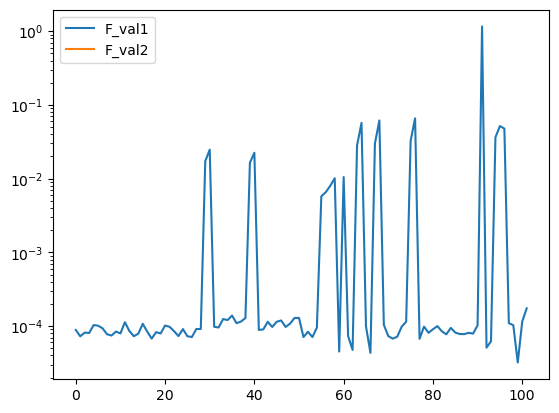

In [2]:
for j in range(102):
    x = X[j, :].T
    x = np.concatenate((Transform_matrix @ x[:3], Transform_matrix_rotation @ x[3:6]))
    L = min(309.5 * 1e-3, 309.5 * 1e-3 + x[2] * 1e-3)
    x[2] = max(x[2], 0)

    A = aa[j, :].T - SS
    B = bb[j, :].T - SS
    C = cc[j, :].T - SS
    D = dd[j, :].T - SS
    E = ee[j, :].T - SS

    f_presc = np.concatenate((A * 2.2 / 1e6, B * 2.2 / 1e6, C * 2.2 / 1e6, D * 2.2 / 1e6, E * 2.2 / 1e6)) * 1e3
    f_presc[[2, 3, 6, 7]] = f_presc[[6, 7, 2, 3]]  # Swapping axes => B<-->D

    # Assuming DE, fmin_beres, and valueF_DE are implemented elsewhere
    #x, fout, it = DE(S * 1e-3, f_presc, v, n, L, beta_min, beta_max, pCR, 1e-6)
    #F_val1[j] = valueF_DE(x, S * 1e-3, f_presc, v, n, L)
    
    
    f_presc = jnp.array(f_presc, dtype=jnp.float64)
    v = jnp.array(v, dtype=jnp.float64)
    n = jnp.array(n, dtype=jnp.float64)


    def ddf(x):
        H = hessF(x, S, f_presc, v, n, L)
        return H


    def df(x):
        H = gradF(x, S, f_presc, v, n, L)
        return H


    def f(x):
        H = valF(x, S, f_presc, v, n, L)
        return H


    x0 = jnp.array((np.random.rand(6) - 0.5) * 0.00001*0, dtype=jnp.float64)

    res = newton(f, df, ddf, x0, tolf=1e-5, tolg=1e-3, maxit=30, verbose=False)
    print(f"It: {j} nit: {res.nit}, F: {res.fun}")
    
    F_val1[j] = res.fun
    # x, it2 = fmin_beres(S * 1e-3, f_presc, v, n, L, 1000, 1e-6)
    #F_val2[j] = valueF_DE(x, S * 1e-3, f_presc, v, n, L)

# Plotting
plt.figure()
plt.plot(F_val1, label='F_val1')
plt.plot(F_val2, label='F_val2')
plt.yscale('log')
plt.legend()
plt.show()

In [3]:
j = 10
x = X[j, :].T
x = np.concatenate((Transform_matrix @ x[:3], Transform_matrix_rotation @ x[3:6]))
L = min(309.5 * 1e-3, 309.5 * 1e-3 + x[2] * 1e-3)
x[2] = max(x[2], 0)

A = aa[j, :].T - SS
B = bb[j, :].T - SS
C = cc[j, :].T - SS
D = dd[j, :].T - SS
E = ee[j, :].T - SS

f_presc = np.concatenate((A * 2.2 / 1e6, B * 2.2 / 1e6, C * 2.2 / 1e6, D * 2.2 / 1e6, E * 2.2 / 1e6)) * 1e3
f_presc[[2, 3, 6, 7]] = f_presc[[6, 7, 2, 3]]  # Swapping axes => B<-->D

# Assuming DE, fmin_beres, and valueF_DE are implemented elsewhere
#x, fout, it = DE(S * 1e-3, f_presc, v, n, L, beta_min, beta_max, pCR, 1e-6)
#F_val1[j] = valueF_DE(x, S * 1e-3, f_presc, v, n, L)
F_val1[j] = np.linalg.norm(f_presc)
#x, it2 = fmin_beres(S * 1e-3, f_presc, v, n, L, 1000, 1e-6)
#F_val2[j] = valueF_DE(x, S * 1e-3, f_presc, v, n, L)
F_val2[j] = np.linalg.norm(S)

In [4]:

f_presc = jnp.array(f_presc, dtype=jnp.float64)
v = jnp.array(v, dtype=jnp.float64)
n = jnp.array(n, dtype=jnp.float64)

def ddf(x):
    H = hessF(x, S, f_presc, v, n, L)
    return H


def df(x):
    H = gradF(x, S, f_presc, v, n, L)
    return H


def f(x):
    H = valF(x, S, f_presc, v, n, L)
    return H


In [7]:


x0 = jnp.array((np.random.rand(6) - 0.5) * 0.1, dtype=jnp.float64)

res = newton(f, df, ddf, x0, tolf=1e-5, tolg=1e-3, maxit=1000, verbose=True)

it=1, f=13.67380, fstep = 6.80279e+00, ||g||=858.20906, nitf=24, a=2.50399e-01
it=2, f=1.30791, fstep = 1.23659e+01, ||g||=633.16030, nitf=24, a=9.99995e-01
it=3, f=0.33046, fstep = 9.77446e-01, ||g||=97.17183, nitf=24, a=5.40383e-01
it=4, f=0.07980, fstep = 2.50665e-01, ||g||=29.78030, nitf=24, a=2.13632e-01
it=5, f=0.00502, fstep = 7.47824e-02, ||g||=29.79237, nitf=24, a=9.99995e-01
it=6, f=0.00020, fstep = 4.81277e-03, ||g||=6.54829, nitf=24, a=9.99995e-01
it=7, f=0.00017, fstep = 2.98445e-05, ||g||=0.45928, nitf=24, a=9.94461e-01
it=8, f=0.00017, fstep = 4.46318e-10, ||g||=0.00307, nitf=24, a=9.99913e-01
it=9, f=0.00017, fstep = 1.29833e-17, ||g||=0.00000, nitf=24, a=6.04852e-01


In [22]:
xn = np.array(res.x)
Sn = np.array(S)
fn = np.array(f_presc)
vn = np.array(v)
nn = np.array(n)
valFnumba(xn, Sn, fn, vn, nn, L)

0.00017436763762558588

In [ ]:
from value_F import value_F_raw

In [57]:
valF2 = jax.jit(value_F_raw, inline=True, static_argnums=(5,))

In [64]:
valF(res.x, S, f_presc, v, n, L)

Array(0.00017437, dtype=float64)

In [76]:
val_f_unrolled(res.x, f_presc, L)

Array(0.00017437, dtype=float64)

In [81]:
valF2 = jax.jit(val_f_unrolled, inline=True, static_argnums=(2,))

In [80]:
%%timeit

valF2(res.x, f_presc, L)

2.71 µs ± 24.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [85]:
%timeit _ =valNumba(xn, fn, L)

211 ns ± 4.06 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [59]:
%timeit _ = valF2(res.x, S, f_presc, v, n, L)

3.42 µs ± 35.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
%timeit _ = gradF(res.x, S, f_presc, v, n, L)

4.26 µs ± 46.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [20]:
%timeit _ = hessF(res.x, S, f_presc, v, n, L)

10.9 µs ± 142 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
%%timeit
es = newton(f, df, ddf, x0, tolf=1e-5, tolg=1e-3, maxit=1000, verbose=False)


8.21 ms ± 85.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
L

0.2095

In [29]:
from value_F import value_F_raw

In [31]:
vf = numba.jit(value_F_raw, nopython=True)

In [9]:
%load_ext line_profiler

In [10]:
%lprun -f newton res = newton(f, df, ddf, x0, tolf=1e-5, tolg=1e-3, maxit=1000, verbose=True)

it=1, f=13.67380, fstep = 6.80279e+00, ||g||=858.20906, nitf=24, a=2.50399e-01
it=2, f=1.30791, fstep = 1.23659e+01, ||g||=633.16030, nitf=24, a=9.99995e-01
it=3, f=0.33046, fstep = 9.77446e-01, ||g||=97.17183, nitf=24, a=5.40383e-01
it=4, f=0.07980, fstep = 2.50665e-01, ||g||=29.78030, nitf=24, a=2.13632e-01
it=5, f=0.00502, fstep = 7.47824e-02, ||g||=29.79237, nitf=24, a=9.99995e-01
it=6, f=0.00020, fstep = 4.81277e-03, ||g||=6.54829, nitf=24, a=9.99995e-01
it=7, f=0.00017, fstep = 2.98445e-05, ||g||=0.45928, nitf=24, a=9.94461e-01
it=8, f=0.00017, fstep = 4.46318e-10, ||g||=0.00307, nitf=24, a=9.99913e-01
it=9, f=0.00017, fstep = 1.29833e-17, ||g||=0.00000, nitf=24, a=6.04852e-01


Timer unit: 1e-09 s

Total time: 0.0123664 s
File: /home/ber0061/Repositories/kamera_sympy/Michal_DE/minimizers.py
Function: newton at line 88

Line #      Hits         Time  Per Hit   % Time  Line Contents
    88                                           def newton(f, df, ddf, x0, tolf=1e-6, tolg=1e-3, maxit=1000, verbose=False):
    89                                               """
    90                                               Newton's method for function minimization
    91                                           
    92                                               Parameters
    93                                               ----------
    94                                               f : function
    95                                                   The objective function to be minimized.
    96                                               df : function
    97                                                   The gradient of the objective function.
    98    

In [9]:
x0 = jnp.array((np.random.rand(6) -0.5)*0.1, dtype=jnp.float64)

res = newton(f, df, ddf, x0, tolf=1e-5, tolg=1e-3, maxit=1000, verbose=True)

it=1, f=0.01307, fstep = 2.25707e+00, ||g||=180.13242, nitf=5, a=9.54915e-01
it=2, f=0.00125, fstep = 1.18254e-02, ||g||=8.13530, nitf=5, a=9.54915e-01
it=3, f=0.00013, fstep = 1.12176e-03, ||g||=1.61034, nitf=5, a=8.99187e-01
it=4, f=0.00008, fstep = 4.66336e-05, ||g||=0.60964, nitf=5, a=9.54915e-01
it=5, f=0.00008, fstep = 7.74889e-08, ||g||=0.02955, nitf=5, a=9.54915e-01
it=6, f=0.00008, fstep = 5.95901e-09, ||g||=0.00135, nitf=5, a=3.36881e-01
it=7, f=0.00008, fstep = -1.55705e-09, ||g||=0.00087, nitf=5, a=4.27051e-01


In [11]:
x = jnp.array([-0.000160390229984,0.024819979466230,-0.000959178023871,-0.019817011094425,0.000933595792212,-0.000653356989351], dtype=jnp.float64)

In [16]:
value_F_raw(x, S*1e-3, f_presc, v, n, L)

Array(0.8899881, dtype=float32)

In [82]:
import numba

@numba.jit(nopython=True)
def valNumba(input_x, f_obs, L):
    X = input_x[0]
    Y = input_x[1]
    Z = input_x[2]
    alpha = input_x[3]
    beta = input_x[4]
    gama = input_x[5]
    f_obs1 = f_obs[0]
    f_obs2 = f_obs[1]
    f_obs3 = f_obs[2]
    f_obs4 = f_obs[3]
    f_obs5 = f_obs[4]
    f_obs6 = f_obs[5]
    f_obs7 = f_obs[6]
    f_obs8 = f_obs[7]
    f_obs9 = f_obs[8]
    f_obs10 = f_obs[9]
    x0 = np.cos(alpha)
    x1 = np.cos(beta)
    x2 = np.abs(Z * x0 / x1)
    x3 = x2 / x0**2
    x4 = (L + x3 - 0.008)**(-1.0)
    x5 = np.sin(gama)
    x6 = x1**2
    x7 = np.sin(alpha)
    x8 = np.cos(gama)
    x9 = np.sin(beta)
    x10 = x0 * x5
    x11 = x10 * x9 + x7 * x8
    x12 = -x0 * x8 + x5 * x7 * x9
    x13 = (x11**2 + x12**2 + x5**2 * x6)**(-1.0)
    x14 = L * x9 + X
    x15 = x14 * x9
    x16 = x0 * x1
    x17 = L * x16 + Z
    x18 = x16 * x17
    x19 = x1 * x7
    x20 = L * x19
    x21 = -Y + x20
    x22 = -x21
    x23 = -x1 * x22 * x7 + x15 + x18
    x24 = -1 / x23
    x25 = x3 * x9
    x26 = X - x25
    x27 = x26 * x9
    x28 = x1 * x2 / x0
    x29 = x16 * (Z - x28)
    x30 = Y + x19 * x3
    x31 = -x1 * x30 * x7 + x27 + x29
    x32 = -x31
    x33 = x24 * x32
    x34 = -X + x25
    x35 = x14 * x33 + x34
    x36 = x1 * x5
    x37 = -Z + x28
    x38 = x17 * x33 + x37
    x39 = -x12
    x40 = x22 * x24 * x32 - x30
    x41 = x14 + 0.05
    x42 = 0.05 * x9
    x43 = 0.05 * x19
    x44 = x42 + x43
    x45 = (-x23 - x44)**(-1.0)
    x46 = -x31 - x44
    x47 = x26 + 0.05
    x48 = x41 * x45 * x46 - x47
    x49 = x17 * x45 * x46 + x37
    x50 = -x21 - 0.05
    x51 = x30 - 0.05
    x52 = x45 * x46 * x50 - x51
    x53 = x14 - 0.05
    x54 = -x42 + x43
    x55 = (-x23 - x54)**(-1.0)
    x56 = -x31 - x54
    x57 = x55 * x56
    x58 = x34 + 0.05
    x59 = x53 * x57 + x58
    x60 = x17 * x57 + x37
    x61 = x50 * x55 * x56 - x51
    x62 = (-x15 - x18 + x19 * x22 + x44)**(-1.0)
    x63 = x19 * x30 - x27 - x29 + x44
    x64 = x62 * x63
    x65 = x53 * x64 + x58
    x66 = x17 * x64 + x37
    x67 = Y - x20 + 0.05
    x68 = x30 + 0.05
    x69 = x62 * x63 * x67 - x68
    x70 = x42 - x43
    x71 = (-x23 - x70)**(-1.0)
    x72 = -x31 - x70
    x73 = x41 * x71 * x72 - x47
    x74 = x17 * x71 * x72 + x37
    x75 = x67 * x71 * x72 - x68
    x76 = x10 * x6 + x11 * x9
    x77 = -x39 * x9 + x5 * x6 * x7
    x78 = x11 * x19 + x16 * x39
    x79 = (x76**2 + x77**2 + x78**2)**(-1.0)
    return (64.0 * (-0.125 * f_obs1 + x4 * x79 * (x35 * x78 + x38 * x77 + x40 * x76))**2 +
            64.0 * (-0.125 * f_obs10 + x13 * x4 * (x11 * x49 - x36 * x48 + x39 * x52))**2 +
            64.0 * (-0.125 * f_obs2 + x13 * x4 * (x11 * x38 - x35 * x36 + x39 * x40))**2 +
            64.0 * (-0.125 * f_obs3 + x4 * x79 * (x59 * x78 + x60 * x77 + x61 * x76))**2 +
            64.0 * (-0.125 * f_obs4 + x13 * x4 * (x11 * x60 - x36 * x59 + x39 * x61))**2 +
            64.0 * (-0.125 * f_obs5 + x4 * x79 * (x65 * x78 + x66 * x77 + x69 * x76))**2 +
            64.0 * (-0.125 * f_obs6 + x13 * x4 * (x11 * x66 - x36 * x65 + x39 * x69))**2 +
            64.0 * (-0.125 * f_obs7 + x4 * x79 * (x73 * x78 + x74 * x77 + x75 * x76))**2 +
            64.0 * (-0.125 * f_obs8 + x13 * x4 * (x11 * x74 - x36 * x73 + x39 * x75))**2 +
            64.0 * (-0.125 * f_obs9 + x4 * x79 * (x48 * x78 + x49 * x77 + x52 * x76))**2)

In [101]:
def fnc(x_input, f_obs, L):
    vec_XYZ = x_input[0:3]
    alpha = x_input[3]
    beta = x_input[4]
    gama = x_input[5]
    v = jnp.array([0.0, 0.0, -1.0], dtype=jnp.float32)
    n = jnp.array([0.0, 1.0, 0.0], dtype=jnp.float32)
    ff = 0.008
    Z = vec_XYZ[2]

    # Rotation matrices Rx, Ry, Rz
    Rx = jnp.array([[1, 0, 0],
                    [0, jnp.cos(alpha), -jnp.sin(alpha)],
                    [0, jnp.sin(alpha), jnp.cos(alpha)]], dtype=jnp.float32)
    Ry = jnp.array([[jnp.cos(beta), 0, jnp.sin(beta)],
                    [0, 1, 0],
                    [-jnp.sin(beta), 0, jnp.cos(beta)]], dtype=jnp.float32)
    Rz = jnp.array([[jnp.cos(gama), -jnp.sin(gama), 0],
                    [jnp.sin(gama), jnp.cos(gama), 0], [0, 0, 1]], dtype=jnp.float32)

    R = Rx @ Ry @ Rz

    x = vec_XYZ - L * R @ v
    o = R @ v

    # Calculate 'a' using dot products
    a = jnp.sqrt(((-o[0] * Z) / (o[2]))**2 + (-(o[1] * Z) / (o[2]))**2 + Z * Z)

    # Calculate Q
    Q = a * o + vec_XYZ

    s_2 = R @ n
    s_1 = jnp.cross(o, s_2)
    s_1norm = jnp.sum(s_1**2)
    s_2norm = jnp.sum(s_2**2)

    M = jnp.array([[0, 0, 0],
                   [0.05, 0.05, 0],
                   [0.05, -0.05, 0],
                   [-0.05, -0.05, 0],
                   [-0.05, 0.05, 0]], dtype=jnp.float32)
    diff_sum = 0
    
    for i in range(5):
        # Substitute the symbols from M for S_x, S_y, S_z in f_1 and f_2
        Sip = M[i, :]
        Sip_proj = Sip + (o.dot(Q) - o.dot(Sip)) * (x - Sip) / (o.dot(x) - o.dot(Sip))
        # Calculate k_1 and k_2
        k_1 = (Sip_proj - Q).dot(s_1) / s_1norm
        k_2 = (Sip_proj - Q).dot(s_2) / s_2norm

        # Calculate image plane coordinates f_1 and f_2
        f_1_i = k_1 * ff / (a + L - ff)
        f_2_i = k_2 * ff / (a + L - ff)
        # Store the results in the matrix (also convert to mm)
        diff_sum += (f_obs[2 * i] - f_1_i * 1e3)**2
        diff_sum += (f_obs[2 * i + 1] - f_2_i * 1e3)**2

    return diff_sum

In [102]:
%%timeit

fnc(res.x, f_presc, L)

3.48 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
fnc_jit = jax.jit(fnc, inline=True)

In [110]:
%%timeit
fnc_jit(res.x, f_presc, L)

3.88 µs ± 11.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [115]:
import numpy as np


def fnc2(x_input, f_obs, L):
    vec_XYZ = x_input[0:3]
    alpha = x_input[3]
    beta = x_input[4]
    gama = x_input[5]
    v = np.array([0.0, 0.0, -1.0], dtype=np.float64)
    n = np.array([0.0, 1.0, 0.0], dtype=np.float64)
    ff = 0.008
    Z = vec_XYZ[2]

    # Rotation matrices Rx, Ry, Rz
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]], dtype=np.float64)
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]], dtype=np.float64)
    Rz = np.array([[np.cos(gama), -np.sin(gama), 0],
                   [np.sin(gama), np.cos(gama), 0], [0, 0, 1]], dtype=np.float64)

    R = Rx @ Ry @ Rz

    x = vec_XYZ - L * R @ v
    o = R @ v

    # Calculate 'a' using dot products
    a = np.sqrt(((-o[0] * Z) / (o[2]))**2 + (-(o[1] * Z) / (o[2]))**2 + Z * Z)

    # Calculate Q
    Q = a * o + vec_XYZ

    s_2 = R @ n
    s_1 = np.cross(o, s_2)
    s_1norm = np.sum(s_1**2)
    s_2norm = np.sum(s_2**2)

    M = np.array([[0, 0, 0],
                  [0.05, 0.05, 0],
                  [0.05, -0.05, 0],
                  [-0.05, -0.05, 0],
                  [-0.05, 0.05, 0]], dtype=np.float64)

    diff_sum = 0

    for i in range(5):
        # Substitute the symbols from M for S_x, S_y, S_z in f_1 and f_2
        Sip = M[i, :]
        Sip_proj = Sip + (o.dot(Q) - o.dot(Sip)) * (x - Sip) / (o.dot(x) - o.dot(Sip))
        # Calculate k_1 and k_2
        k_1 = (Sip_proj - Q).dot(s_1) / s_1norm
        k_2 = (Sip_proj - Q).dot(s_2) / s_2norm

        # Calculate image plane coordinates f_1 and f_2
        f_1_i = k_1 * ff / (a + L - ff)
        f_2_i = k_2 * ff / (a + L - ff)
        # Store the results in the matrix (also convert to mm)
        diff_sum += (f_obs[2 * i] - f_1_i * 1e3)**2
        diff_sum += (f_obs[2 * i + 1] - f_2_i * 1e3)**2

    return diff_sum

In [120]:
fnc3 = numba.jit(fnc2, nopython=True)

In [121]:
fnc3(xn,fn,L)

/usr/lib/python3.11/site-packages/numba/core/utils.py:213: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/usr/lib/python3.11/site-packages/numba/cpython/listobj.py", line 1131, in list_to_list
    assert fromty.dtype == toty.dtype
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  warnings.warn(msg,


AssertionError: Failed in nopython mode pipeline (step: native lowering)


In [122]:
def val_f_unrolled(input_x, f_obs, L):
    X = input_x[0, :]
    Y = input_x[1, :]
    Z = input_x[2, :]
    alpha = input_x[3, :]
    beta = input_x[4, :]
    gama = input_x[5, :]
    f_obs1 = f_obs[0]
    f_obs2 = f_obs[1]
    f_obs3 = f_obs[2]
    f_obs4 = f_obs[3]
    f_obs5 = f_obs[4]
    f_obs6 = f_obs[5]
    f_obs7 = f_obs[6]
    f_obs8 = f_obs[7]
    f_obs9 = f_obs[8]
    f_obs10 = f_obs[9]
    x0 = np.cos(alpha)
    x1 = np.cos(beta)
    x2 = np.abs(Z * x0 / x1)
    x3 = x2 / x0**2
    x4 = (L + x3 - 0.008)**(-1.0)
    x5 = np.sin(gama)
    x6 = x1**2
    x7 = np.sin(alpha)
    x8 = np.cos(gama)
    x9 = np.sin(beta)
    x10 = x0 * x5
    x11 = x10 * x9 + x7 * x8
    x12 = -x0 * x8 + x5 * x7 * x9
    x13 = (x11**2 + x12**2 + x5**2 * x6)**(-1.0)
    x14 = L * x9 + X
    x15 = x14 * x9
    x16 = x0 * x1
    x17 = L * x16 + Z
    x18 = x16 * x17
    x19 = x1 * x7
    x20 = L * x19
    x21 = -Y + x20
    x22 = -x21
    x23 = -x1 * x22 * x7 + x15 + x18
    x24 = -1 / x23
    x25 = x3 * x9
    x26 = X - x25
    x27 = x26 * x9
    x28 = x1 * x2 / x0
    x29 = x16 * (Z - x28)
    x30 = Y + x19 * x3
    x31 = -x1 * x30 * x7 + x27 + x29
    x32 = -x31
    x33 = x24 * x32
    x34 = -X + x25
    x35 = x14 * x33 + x34
    x36 = x1 * x5
    x37 = -Z + x28
    x38 = x17 * x33 + x37
    x39 = -x12
    x40 = x22 * x24 * x32 - x30
    x41 = x14 + 0.05
    x42 = 0.05 * x9
    x43 = 0.05 * x19
    x44 = x42 + x43
    x45 = (-x23 - x44)**(-1.0)
    x46 = -x31 - x44
    x47 = x26 + 0.05
    x48 = x41 * x45 * x46 - x47
    x49 = x17 * x45 * x46 + x37
    x50 = -x21 - 0.05
    x51 = x30 - 0.05
    x52 = x45 * x46 * x50 - x51
    x53 = x14 - 0.05
    x54 = -x42 + x43
    x55 = (-x23 - x54)**(-1.0)
    x56 = -x31 - x54
    x57 = x55 * x56
    x58 = x34 + 0.05
    x59 = x53 * x57 + x58
    x60 = x17 * x57 + x37
    x61 = x50 * x55 * x56 - x51
    x62 = (-x15 - x18 + x19 * x22 + x44)**(-1.0)
    x63 = x19 * x30 - x27 - x29 + x44
    x64 = x62 * x63
    x65 = x53 * x64 + x58
    x66 = x17 * x64 + x37
    x67 = Y - x20 + 0.05
    x68 = x30 + 0.05
    x69 = x62 * x63 * x67 - x68
    x70 = x42 - x43
    x71 = (-x23 - x70)**(-1.0)
    x72 = -x31 - x70
    x73 = x41 * x71 * x72 - x47
    x74 = x17 * x71 * x72 + x37
    x75 = x67 * x71 * x72 - x68
    x76 = x10 * x6 + x11 * x9
    x77 = -x39 * x9 + x5 * x6 * x7
    x78 = x11 * x19 + x16 * x39
    x79 = (x76**2 + x77**2 + x78**2)**(-1.0)
    return (64.0 * (-0.125 * f_obs1 + x4 * x79 * (x35 * x78 + x38 * x77 + x40 * x76))**2 +
            64.0 * (-0.125 * f_obs10 + x13 * x4 * (x11 * x49 - x36 * x48 + x39 * x52))**2 +
            64.0 * (-0.125 * f_obs2 + x13 * x4 * (x11 * x38 - x35 * x36 + x39 * x40))**2 +
            64.0 * (-0.125 * f_obs3 + x4 * x79 * (x59 * x78 + x60 * x77 + x61 * x76))**2 +
            64.0 * (-0.125 * f_obs4 + x13 * x4 * (x11 * x60 - x36 * x59 + x39 * x61))**2 +
            64.0 * (-0.125 * f_obs5 + x4 * x79 * (x65 * x78 + x66 * x77 + x69 * x76))**2 +
            64.0 * (-0.125 * f_obs6 + x13 * x4 * (x11 * x66 - x36 * x65 + x39 * x69))**2 +
            64.0 * (-0.125 * f_obs7 + x4 * x79 * (x73 * x78 + x74 * x77 + x75 * x76))**2 +
            64.0 * (-0.125 * f_obs8 + x13 * x4 * (x11 * x74 - x36 * x73 + x39 * x75))**2 +
            64.0 * (-0.125 * f_obs9 + x4 * x79 * (x48 * x78 + x49 * x77 + x52 * x76))**2)

In [131]:
%%timeit
val_f_unrolled(np.tile(xn, (1000, 1)).T, fn,L)

221 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [145]:
val_f_unrolled_jit = numba.jit(val_f_unrolled, nopython=True, parallel=True, fastmath=True, boundscheck=False)

In [146]:
xxin = np.array(np.tile(xn, (1000, 1)).T, dtype=np.float32)
fnin = np.array(fn, dtype=np.float32)

val_f_unrolled_jit(xxin, fnin, L)


array([0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017438,
       0.00017438, 0.00017438, 0.00017438, 0.00017438, 0.00017

In [147]:
%%timeit
val_f_unrolled_jit(xxin, fnin, L)

20.8 µs ± 723 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
